In [15]:
!pip install pandas sqlalchemy psycopg2-binary matplotlib seaborn

In [64]:
import getpass
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote_plus
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError
from urllib.parse import quote_plus
from statsmodels.tsa.seasonal import seasonal_decompose
import getpass

In [17]:
host = input("Host (default: localhost): ") or "localhost"
port = input("Port (default: 5432): ") or "5432"
database = input("Database name: ")
username = input("Username: ")
password = getpass.getpass("Password (hidden): ")

Host (default: localhost):  localhost
Port (default: 5432):  5432
Database name:  assignment_APDV
Username:  AbhishekJ
Password (hidden):  ········


In [18]:
csv_file = r"C:\Users\LENOVO\OneDrive\Desktop\GreenDataFolder\MTM06.20251202T161217.csv"
df = pd.read_csv(csv_file)
print(":D CSV loaded. Shape:", df.shape)

:D CSV loaded. Shape: (56880, 5)


In [19]:
encoded_password = quote_plus(password)
db_url = f"postgresql+psycopg2://{username}:{encoded_password}@{host}:{port}/{database}"
engine = create_engine(db_url)

In [20]:
df['Year'] = df['Month'].str.extract(r'(\d{4})').astype(int)
df = df[(df['Year'] >= 2009) & (df['Year'] <= 2023)]
df['Date'] = pd.to_datetime(df['Month'], format='%Y %B')

In [21]:
df.to_sql("raw_dataset", engine, if_exists="replace", index=False)
print("CSV uploaded to PostgreSQL as 'raw_dataset'")

CSV uploaded to PostgreSQL as 'raw_dataset'


In [22]:
with engine.connect() as conn:
    tables = conn.execute(
        text("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")
    ).fetchall()

print("Tables in DB:", tables)

Tables in DB: [('clean_dataset',), ('weather_processed',), ('weather_yearly_summary',), ('raw_dataset',)]


In [23]:
with engine.connect() as conn:
    rows = conn.execute(
        text("SELECT * FROM raw_dataset LIMIT 5;")
    ).fetchall()

for row in rows:
    print(row)

('Mean Maximum Temperature', '2009 January', 'Malin Head', 'Degrees C', 7.8, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Claremorris', 'Degrees C', 7.2, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Valentia Observatory', 'Degrees C', 9.7, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Belmullet', 'Degrees C', 8.4, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Shannon Airport', 'Degrees C', 8.1, 2009, datetime.datetime(2009, 1, 1, 0, 0))


In [24]:
#cleaning data using SQL
def run_sql(engine, sql):
    """
    Execute a SQL statement with SQLAlchemy 2.x
    """
    with engine.connect() as conn:
        conn.execute(text(sql))
        conn.commit()

In [25]:
sql_create_clean = """
CREATE TABLE IF NOT EXISTS clean_dataset AS
SELECT *
FROM raw_dataset
WHERE 1=0;  -- create structure only
"""
run_sql(engine, sql_create_clean)
print("Clean table created (empty)!")

Clean table created (empty)!


In [26]:
with engine.connect() as conn:
    columns = conn.execute(
        text("SELECT column_name FROM information_schema.columns WHERE table_name='raw_dataset';")
    ).fetchall()

print("Columns in raw_dataset:")
for col in columns:
    print(col[0])

Columns in raw_dataset:
VALUE
Year
Date
Statistic Label
UNIT
Month
Meteorological Weather Station


In [27]:
raw_df = pd.read_sql("SELECT * FROM raw_dataset", engine)
print("Raw data preview:")
raw_df.head()

Raw data preview:


,Statistic Label,Month,Meteorological Weather Station,UNIT,VALUE,Year,Date
0,Mean Maximum Temperature,2009 January,Malin Head,Degrees C,7.8,2009,2009-01-01
1,Mean Maximum Temperature,2009 January,Claremorris,Degrees C,7.2,2009,2009-01-01
2,Mean Maximum Temperature,2009 January,Valentia Observatory,Degrees C,9.7,2009,2009-01-01
3,Mean Maximum Temperature,2009 January,Belmullet,Degrees C,8.4,2009,2009-01-01
4,Mean Maximum Temperature,2009 January,Shannon Airport,Degrees C,8.1,2009,2009-01-01


In [28]:
#replacing nulls
raw_df['Statistic Label'] = raw_df['Statistic Label'].fillna('Unknown')
raw_df['Month'] = raw_df['Month'].fillna('Unknown')
raw_df['Meteorological Weather Station'] = raw_df['Meteorological Weather Station'].fillna('Unknown')
raw_df['UNIT'] = raw_df['UNIT'].fillna('Unknown')

#removing duplicates
clean_df = raw_df.drop_duplicates()
clean_df = raw_df.dropna(subset=['VALUE'])
#normalizing text columns
text_cols = ['Statistic Label', 'Month', 'Meteorological Weather Station', 'UNIT']
for col in text_cols:
    clean_df[col] = clean_df[col].str.title()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_4976\4242864535.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[col] = clean_df[col].str.title()


In [29]:
print(raw_df.isna().sum())

Statistic Label                    0
Month                              0
Meteorological Weather Station     0
UNIT                               0
VALUE                             52
Year                               0
Date                               0
dtype: int64


In [30]:
# Save cleaned data as a new table 'clean_dataset'
clean_df.to_sql('clean_dataset', engine, if_exists='replace', index=False)
print("Clean dataset saved in PostgreSQL as 'clean_dataset'!")

Clean dataset saved in PostgreSQL as 'clean_dataset'!


In [31]:
with engine.connect() as conn:
    result = conn.execute(text("SELECT * FROM clean_dataset LIMIT 10;")).fetchall()
print("Sample rows from clean_dataset:")
for row in result:
    print(row)

Sample rows from clean_dataset:
('Mean Maximum Temperature', '2009 January', 'Malin Head', 'Degrees C', 7.8, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Claremorris', 'Degrees C', 7.2, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Valentia Observatory', 'Degrees C', 9.7, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Belmullet', 'Degrees C', 8.4, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Shannon Airport', 'Degrees C', 8.1, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Dublin Airport', 'Degrees C', 7.2, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Mullingar', 'Degrees C', 6.8, 2009, datetime.datetime(2009, 1, 1, 0, 0))
('Mean Maximum Temperature', '2009 January', 'Cork Airport', 'Degrees C', 7.5, 2009, datetime.datetime(2009, 1

In [32]:
with engine.connect() as conn:
    tables = conn.execute(
        text("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")
    ).fetchall()

print("Tables in PostgreSQL database:")
for t in tables:
    print(t[0])

Tables in PostgreSQL database:
weather_processed
weather_yearly_summary
raw_dataset
clean_dataset


In [33]:
print(clean_df.describe())

              VALUE          Year                           Date
count  12908.000000  12908.000000                          12908
mean       7.912612   2016.014720  2016-06-21 02:26:55.370312960
min      -20.100000   2009.000000            2009-01-01 00:00:00
25%        2.200000   2012.000000            2012-10-01 00:00:00
50%        8.100000   2016.000000            2016-07-01 00:00:00
75%       13.600000   2020.000000            2020-04-01 00:00:00
max       33.000000   2023.000000            2023-12-01 00:00:00
std        8.084978      4.321305                            NaN


In [34]:
clean_df = pd.read_sql("SELECT * FROM clean_dataset", engine)
clean_df = clean_df[clean_df['VALUE'] != 0]
clean_df.to_sql('clean_dataset', engine, if_exists='replace', index=False)
print("Rows with VALUE = 0 removed and table updated!")

Rows with VALUE = 0 removed and table updated!


In [35]:
clean_df['Month'] = pd.to_datetime(clean_df['Month'], format='%Y %B')

In [36]:
#finding duplicate rows in dataset
print(clean_df.duplicated().sum())

0


In [37]:
#counting how frequently each temperature value appears in  dataset
clean_df['VALUE'].value_counts()

VALUE
 6.1     78
 7.7     78
 6.6     76
 13.0    74
 10.4    74
         ..
-15.7     1
-12.2     1
-13.5     1
-12.1     1
-11.1     1
Name: count, Length: 439, dtype: int64

In [38]:
#setting month column as index and sorting it
clean_df= clean_df.set_index('Month').sort_index()

In [39]:
#checking first 5 rows of new filtered dataset
print(clean_df.head())

                     Statistic Label Meteorological Weather Station  \
Month                                                                 
2009-01-01  Mean Maximum Temperature                     Malin Head   
2009-01-01      Mean Air Temperature                   Phoenix Park   
2009-01-01      Mean Air Temperature                   Roches Point   
2009-01-01      Mean Air Temperature                        Markree   
2009-01-01  Mean Minimum Temperature                    Claremorris   

                 UNIT  VALUE  Year       Date  
Month                                          
2009-01-01  Degrees C    7.8  2009 2009-01-01  
2009-01-01  Degrees C    4.3  2009 2009-01-01  
2009-01-01  Degrees C    6.1  2009 2009-01-01  
2009-01-01  Degrees C    3.8  2009 2009-01-01  
2009-01-01  Degrees C    1.2  2009 2009-01-01  


In [40]:
#checking last 5 rows of new filtered dataset
print(clean_df.tail())

                      Statistic Label Meteorological Weather Station  \
Month                                                                  
2023-12-01       Mean Air Temperature                   Cork Airport   
2023-12-01       Mean Air Temperature                       Casement   
2023-12-01       Mean Air Temperature                   Phoenix Park   
2023-12-01   Mean Minimum Temperature                    Claremorris   
2023-12-01  Grass Minimum Temperature                        Markree   

                 UNIT  VALUE  Year       Date  
Month                                          
2023-12-01  Degrees C    7.6  2023 2023-12-01  
2023-12-01  Degrees C    7.4  2023 2023-12-01  
2023-12-01  Degrees C    7.7  2023 2023-12-01  
2023-12-01  Degrees C    4.6  2023 2023-12-01  
2023-12-01  Degrees C   -6.8  2023 2023-12-01  


In [41]:
# checking information of new filtered dataset
print(clean_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12873 entries, 2009-01-01 to 2023-12-01
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Statistic Label                 12873 non-null  object        
 1   Meteorological Weather Station  12873 non-null  object        
 2   UNIT                            12873 non-null  object        
 3   VALUE                           12873 non-null  float64       
 4   Year                            12873 non-null  int64         
 5   Date                            12873 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 704.0+ KB
None


In [42]:
#displaying summary statistics for VALUE column
print("Summary of VALUE Column:")
print(clean_df['VALUE'].describe())

Summary of VALUE Column:
count    12873.000000
mean         7.934126
std          8.085413
min        -20.100000
25%          2.300000
50%          8.200000
75%         13.600000
max         33.000000
Name: VALUE, dtype: float64


In [43]:
print("Unique values:")
#counting unique statistic labels in dataset
print("Statistic Label:", clean_df['Statistic Label'].nunique())
#counting how many different meteorological weather stations are included
print("Weather Stations:", clean_df['Meteorological Weather Station'].nunique())
#counting number of unique measurement units used
print("Units:", clean_df['UNIT'].nunique())

Unique values:
Statistic Label: 6
Weather Stations: 12
Units: 1


In [44]:
print(clean_df.describe())

              VALUE          Year                           Date
count  12873.000000  12873.000000                          12873
mean       7.934126   2016.014604  2016-06-20 23:48:21.980890112
min      -20.100000   2009.000000            2009-01-01 00:00:00
25%        2.300000   2012.000000            2012-10-01 00:00:00
50%        8.200000   2016.000000            2016-07-01 00:00:00
75%       13.600000   2020.000000            2020-04-01 00:00:00
max       33.000000   2023.000000            2023-12-01 00:00:00
std        8.085413      4.320835                            NaN


# Distribution of VALUE

The histogram is indicating distribution of temperature values on the time period from 2009 to 2023

1.Shape of distribution: As we can see that  distribution is approximately bell-shaped telling that it is a Gaussian distribution. The temperature data is mainly found in the center range with lesser data points on both ends.

2.Central tendency: Highest observations lies between 5 degree celsius to 15 degree celsius. This tells that average temperature observed during 2009-2023 is within range.

3.Spread or Variability: Data varies from −15 degree celcius to 30 degree celcius. This indicates presence of both cold and warm extremes. They occur less frequently as compared than moderate values.

4.Tails and extremes: Both left and right tails of  distribution are thin which tells us that extreme low or high values of temperature are rare.  

5.KDE: The KDE (Kernel Density Estimation) line is almost running alongside histogram bars. This further confirms that temperature readings are following a smooth and uniform distribution which is important for statistical analysis, averaging techniques and anomaly detection through standard deviation boundaries.

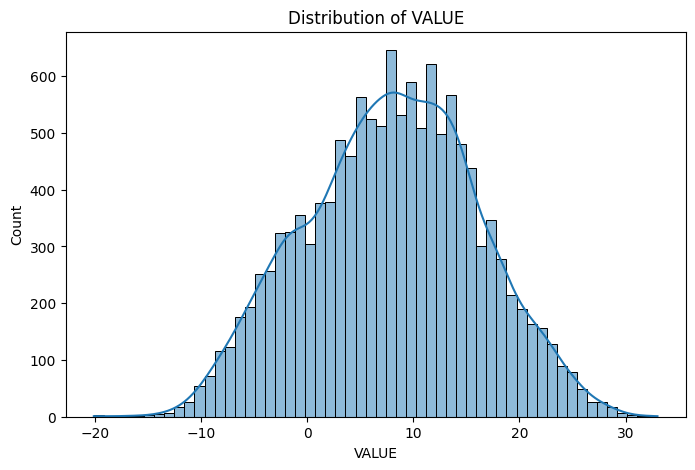

In [45]:
#plotting distribution of VALUE column
plt.figure(figsize=(8,5))
sns.histplot(clean_df['VALUE'], kde=True) #kernel density estimation
plt.title("Distribution of VALUE")
plt.xlabel("VALUE")
plt.ylabel("Count")
plt.show()

# Trend of Value

This line plot tells how temperature values fluctuate over time from 2009 to 2023. The data reveals marked seasonality, where almost regular peaks and troughs have surface and give repetition to apparent annual cycle. The short term variations are sharp. Even though overall range of temperature values remains consistent over years, with some extremes being very high and others being low. That means the seasonal effect dominates, and long term changes are understood better by smoothed trends such as rolling averages.

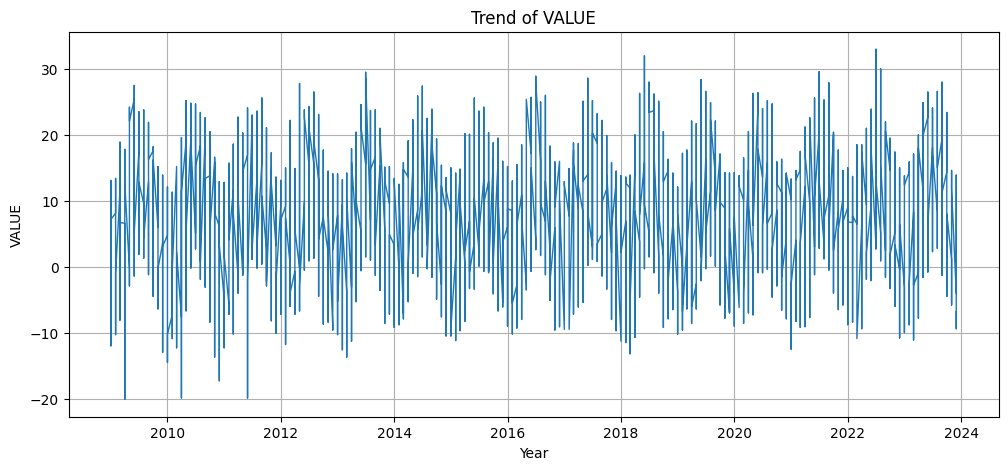

In [46]:
#plotting main time-series trend of VALUE column
plt.figure(figsize=(12,5))
plt.plot(clean_df.index, clean_df['VALUE'], linewidth=1)
plt.title("Trend of VALUE")
plt.xlabel("Year")
plt.ylabel("VALUE")
plt.grid(True)
plt.show()

# Original vs 12 Months Rolling Average 

This plot compares original temperature values with a 12 months rolling average. The rolling average smooths out short term fluctuations and seasonal ups and downs, making long term pattern easier to see. While original values are irregular throughout each year. Rolling mean shows more stable trend over time. Overall smoothed line suggests that temperatures remain relatively consistent across 2009-2023 with a slight upward tendency in recent years. This confirms that most of variation in data is seasonal rather than random.

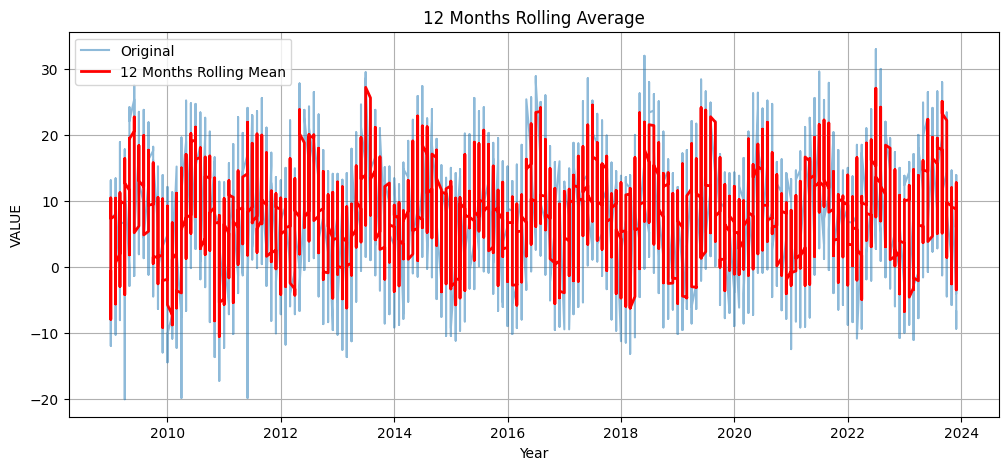

In [47]:
#calculating 12 months rolling average to smooth short term fluctuation
clean_df['rolling_12'] = clean_df['VALUE'].rolling(window=12).mean()

plt.figure(figsize=(12,5))
#plotting original temperature values with lower opacity
plt.plot(clean_df.index, clean_df['VALUE'], alpha=0.5, label='Original')
#plotting 12 months rolling mean to show trend
plt.plot(clean_df.index, clean_df['rolling_12'], color='red', linewidth=2, label='12 Months Rolling Mean')
plt.title("12 Months Rolling Average")
plt.xlabel("Year")
plt.ylabel("VALUE")
plt.legend()
plt.grid(True)
plt.show()

# Seasonal Temperature Patterns by Month

It can be clearly seen from this boxplot that there is a strong seasonal pattern in temperature throughout the year. The median temperatures are lower in the winter months which includes January.February, March, November and December. Higher temperatures are recorded in  summer months from June to August. The dispersion of values is larger during warmer months of the year. Which suggests greater variability and in cold months, the temperatures remain relatively stable. So we can say that it confirms the change in temperatures follows a clear and predictable seasonal cycle.

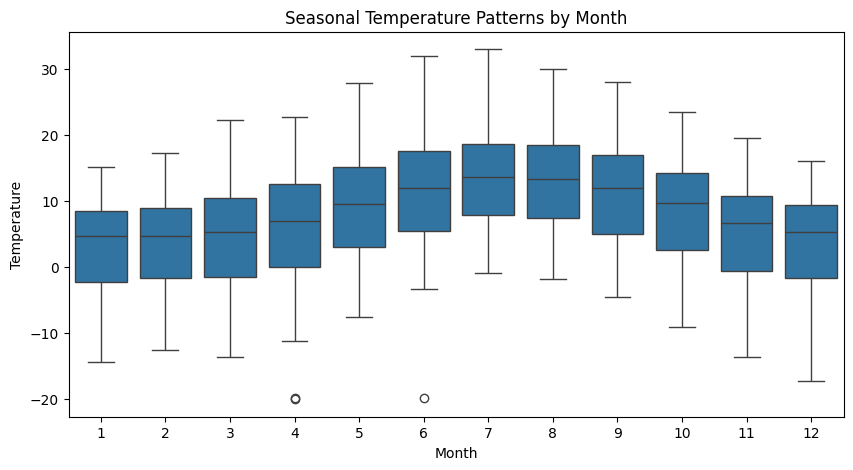

In [48]:
#extracting month number from the datetime index
clean_df['Month_num'] = clean_df.index.month
#creating a boxplot for seasonal temperature patterns
plt.figure(figsize=(10,5))
sns.boxplot(x='Month_num', y='VALUE', data=clean_df)
plt.title("D")
plt.xlabel("Month")
plt.ylabel("Temperature")
plt.show()

# Temperature Trends by Weather Station

This plot compares temperature trends across multiple meteorological weather stations over time of 2009 to 2023. All stations show a similar seasonal pattern with regular increase and decrease each year. Indicating consistent climatic behaviour across locations. Small differences in temperature levels and extremes are visible between stations, the overall trend remains broadly consistent. This suggests that temperature variations are largely driven by regional seasonal effects rather than station specific anomalies.

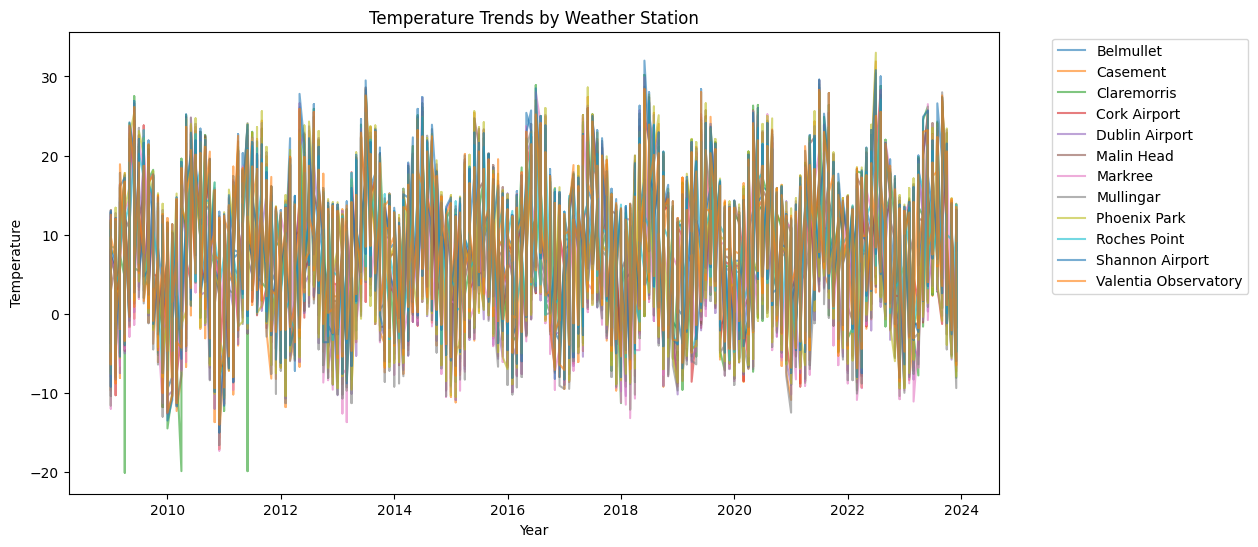

In [49]:
#comparing temperature trends across different meteorological weather stations
plt.figure(figsize=(12,6))

for station, group in clean_df.groupby('Meteorological Weather Station'):
    #plotting time series data for each weather station
    plt.plot(group.index, group['VALUE'], alpha=0.6, label=station)

#placing legend outside plot for better readability
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Temperature Trends by Weather Station")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.show()

# Yearly Average Temperature Trend

The plot shows average temperature for each year during 2009-2023. As there are small year-to-year fluctuations, the overall trend indicates a gradual increase in average temperature over time. Lower averages are observed in early years, whereas more recent years show higher values, suggesting a warming pattern. This highlights a long-term change in temperature rather than short-term seasonal variation.

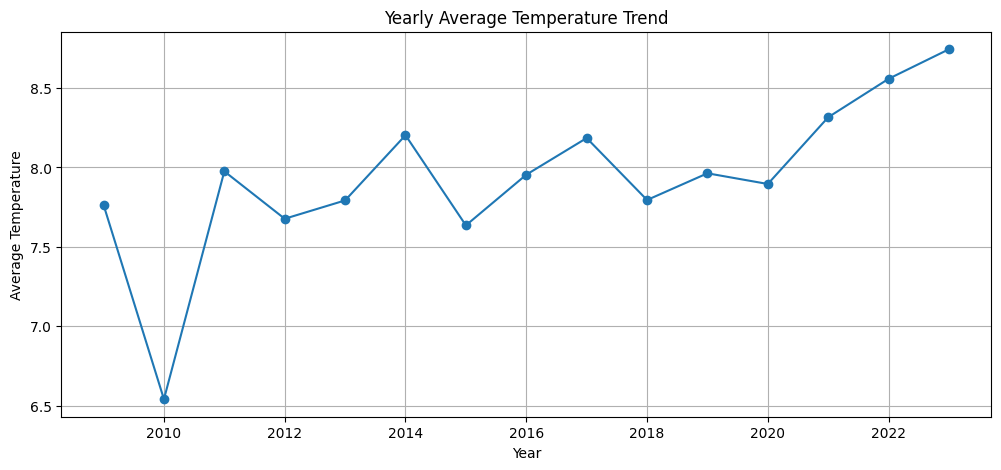

In [50]:
#extracting year from datetime index
clean_df['Year'] = clean_df.index.year

#calculating average temperature for each year
yearly_avg = clean_df.groupby('Year')['VALUE'].mean()

#plotting yearly average temperature trend
plt.figure(figsize=(12,5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Yearly Average Temperature Trend")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.grid(True)
plt.show()


# Year x Month Heatmap

The heatmap shows a clear and consistent seasonal pattern across all years from 2009 to 2023. Cooler temperatures are observed in early and late months of year, while warmer temperatures consistently occur during the mid-year months, particularly from June to August. The similarity of colour patterns across years indicates that seasonal behaviour remains stable over time, with only minor variations in intensity. This suggests that temperature changes are largely driven by seasonal cycles rather than irregular fluctuations.

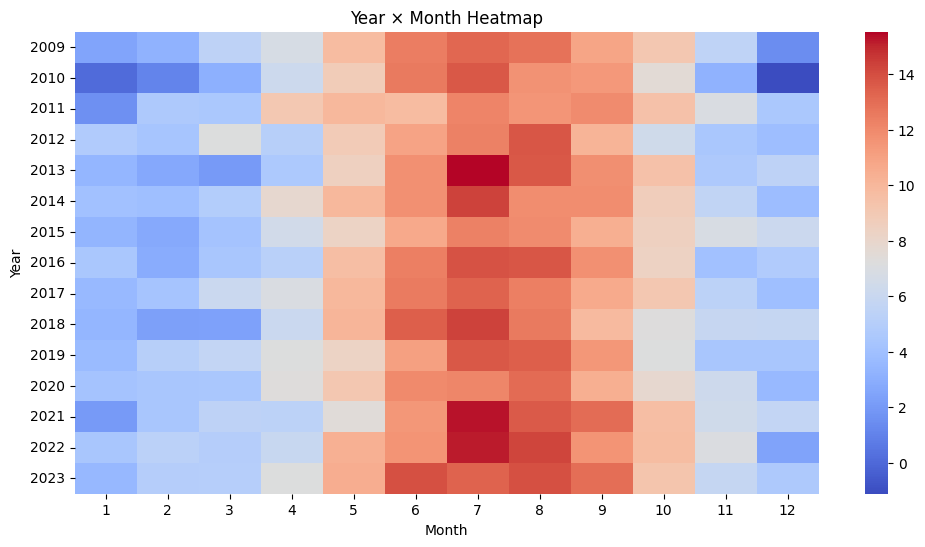

In [51]:
#creating pivot table to analyse seasonal consistency
heatmap_data = clean_df.pivot_table(
    values='VALUE',
    index='Year',
    columns='Month_num',
    aggfunc='mean'
)
#plotting heatmap to visually compare temperature patterns
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title("Year × Month Heatmap")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# Seasonal Decomposition of Temperature Time Series

The decomposition breaks temperature time series into four components: the original data, trend, seasonal pattern, and residuals. The trend component shows a relatively stable long-term behaviour with minor fluctuations over time. The seasonal component highlights a strong and repeating annual cycle, confirming consistent seasonal effects across the study period. The residuals appear randomly scattered, indicating that most of the systematic variation in the data is captured by the trend and seasonal components.

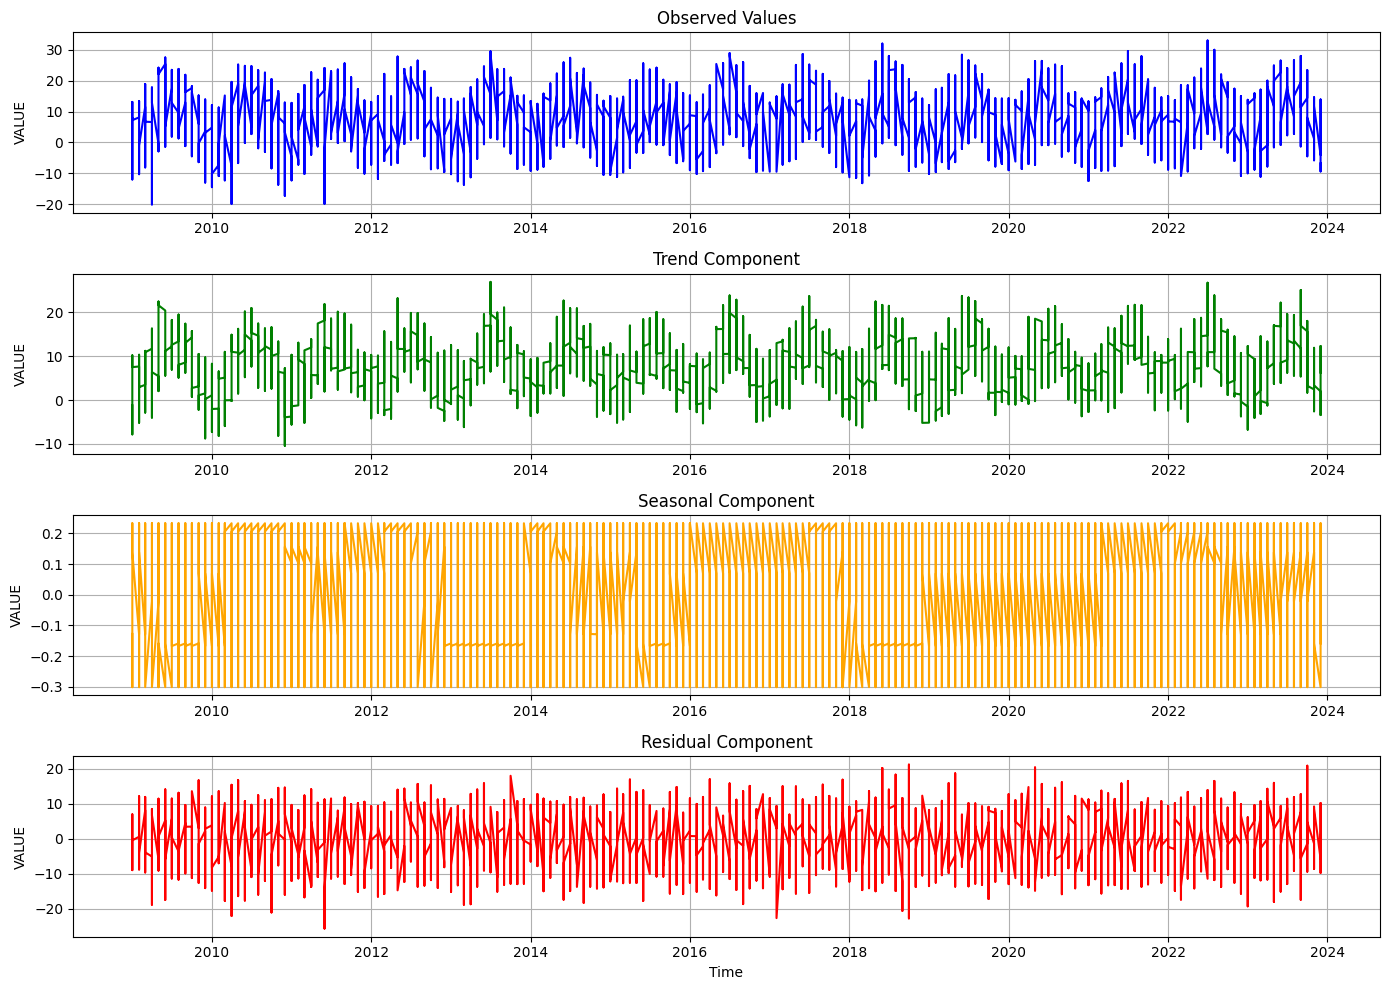

In [65]:
decomposition = seasonal_decompose(clean_df['VALUE'], model='additive', period=12)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
observed = decomposition.observed

# Plot components
plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.plot(observed, label='Observed', color='blue')
plt.title('Observed Values')
plt.ylabel('VALUE')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='green')
plt.title('Trend Component')
plt.ylabel('VALUE')
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.ylabel('VALUE')
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(residual, label='Residual', color='red')
plt.title('Residual Component')
plt.ylabel('VALUE')
plt.xlabel('Time')
plt.grid(True)

plt.tight_layout()
plt.show()

# Temperature Anomalies

The plot highlights temperature values that fall outside the normal range defined by ±2 standard deviations from the mean. Most anomalies appear at the extreme high and low ends of the temperature cycle, indicating unusually hot or cold periods. These anomalous points are scattered across the study period rather than concentrated in a single year, suggesting that extreme temperature events occur intermittently. Overall, this confirms the presence of rare but significant temperature extremes within an otherwise stable seasonal pattern.

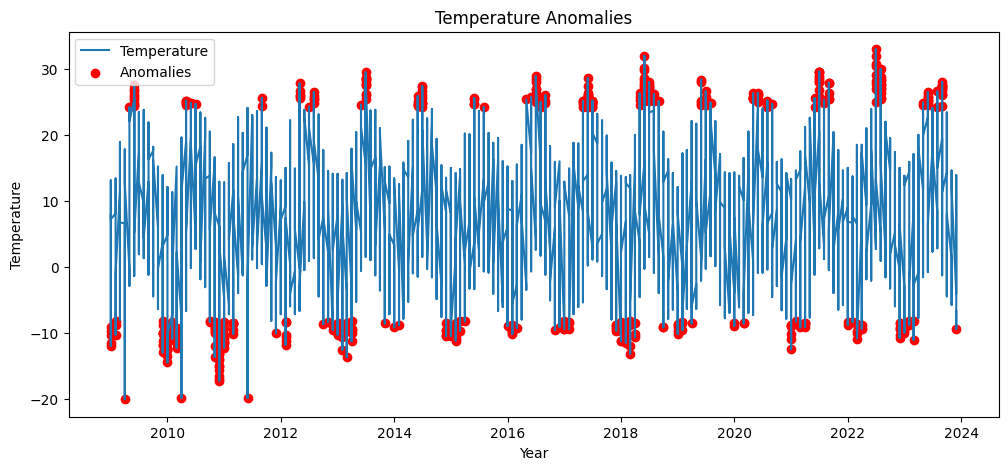

In [54]:
#calculating mean and standard deviation of temperature values
mean_val = clean_df['VALUE'].mean()
std_val = clean_df['VALUE'].std()

#defining upper and lower thresholds using +2 and -2 standard deviations
upper = mean_val + 2 * std_val
lower = mean_val - 2 * std_val

#identifying anomalous temperature values
anomalies = clean_df[(clean_df['VALUE'] > upper) | (clean_df['VALUE'] < lower)]


#plotting original temperature values and highlighting anomalies
plt.figure(figsize=(12,5))
plt.plot(clean_df.index, clean_df['VALUE'], label='Temperature')
plt.scatter(anomalies.index, anomalies['VALUE'], color='red', label='Anomalies')
plt.title("Temperature Anomalies")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [55]:
#resetting index to convert datetime index back into a column
clean_df_processed = clean_df.reset_index()

#storing cleaned and processed dataset into MySQL
clean_df_processed.to_sql(
    name="weather_processed",
    con=engine,
    if_exists="replace",
    index=False
)

print("Processed weather data stored in MySQL table: weather_processed")

Processed weather data stored in MySQL table: weather_processed


query = """
SELECT "Year", AVG("VALUE") AS avg_value
FROM weather_processed
GROUP BY "Year"
ORDER BY "Year";
"""

#running SQL query and storing result in a pandas DataFrame
yearly_df = pd.read_sql(query, engine)

#printing first few rows to verify that query
print("Yearly average values from PostgreSQL:")
display(yearly_df.head())

In [56]:
#creating analytical summary of yearly average temperatures
yearly_summary = yearly_avg.reset_index()

#renaming columns 
yearly_summary.columns = ["Year", "Avg_VALUE"]

#storing analytical summary into MySQL
yearly_summary.to_sql(
    name="weather_yearly_summary",
    con=engine,
    if_exists="replace",
    index=False
)

print("Yearly analytical summary stored in MySQL table: weather_yearly_summary")

Yearly analytical summary stored in MySQL table: weather_yearly_summary


# Research Questions

Research Question 1: Has temperature variability increased or decreased over 2009-2023?

->The rolling 12 months standard deviation shows that temperature variability remains largely stable throughout period with regular short-term fluctuations. While there are occasional spikes indicating periods of higher variability, there is no strong long-term upward or downward trend. This suggests that although temperatures fluctuate seasonally, the overall level of variability has not significantly increased or decreased between 2009 and 2023.

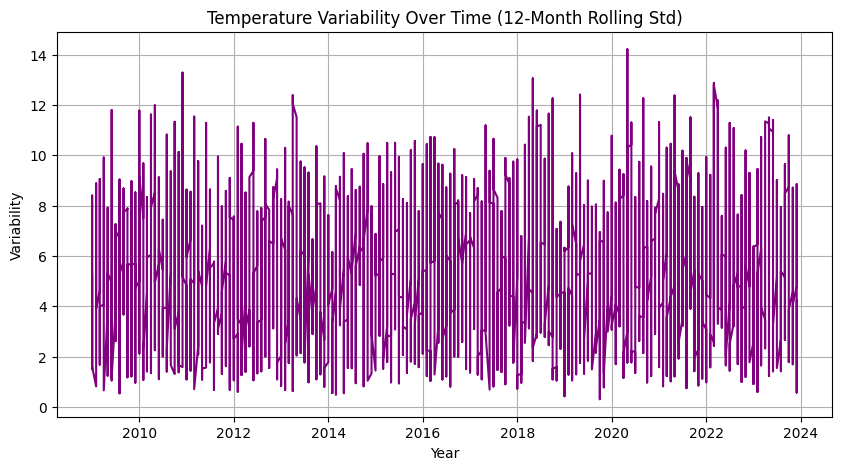

In [57]:
#calculating 12 months rolling standard deviation
rolling_std = clean_df['VALUE'].rolling(window=12).std()

#plotting rolling standard deviation to visualize variability trends
plt.figure(figsize=(10,5))
plt.plot(clean_df.index, rolling_std, color='purple')
plt.title("Temperature Variability Over Time (12-Month Rolling Std)")
plt.xlabel("Year")
plt.ylabel("Variability")
plt.grid(True)
plt.show()

Research Question 2: Which months and years record the highest and lowest average temperature values?

->Highest average temperatures are observed during summer months which are July and August.
July 2013 records the highest average temperature and other warm periods include:
July 2021, July 2022, July 2018, July 2014, August 2022, August 2023, July 2016, June 2023, August 2012

->Lowest average temperatures are observed during winter months which are December, January and February.
December 2010 records the lowest average temperature and other cold periods include:
January 2010, February 2010, December 2009, January 2011, March 2013, January 2021, Febrary 2018, March 2018 and December 2022


In [58]:
query = """
SELECT 
    "Year",
    "Month_num",
    AVG("VALUE") AS avg_temp
FROM weather_processed
GROUP BY "Year", "Month_num"
ORDER BY avg_temp DESC
LIMIT 10;
"""
top_extremes_df = pd.read_sql(query, engine)

print("Top 10 highest average temperature periods:")
display(top_extremes_df)

Top 10 highest average temperature periods:


,Year,Month_num,avg_temp
0,2013,7,15.534722
1,2021,7,15.318056
2,2022,7,15.166197
3,2018,7,14.348611
4,2014,7,14.319718
5,2022,8,14.281944
6,2023,6,13.936620
7,2023,8,13.933333
8,2016,7,13.906944
9,2012,8,13.724242


In [59]:
query = """
SELECT 
    "Year",
    "Month_num",
    AVG("VALUE") AS avg_temp
FROM weather_processed
GROUP BY "Year", "Month_num"
ORDER BY avg_temp ASC
LIMIT 10;
"""
#executing SQL query and loading results into a pandas DataFrame
top_cold_extremes_df = pd.read_sql(query, engine)
#displaying top 10 lowest year-month periods
print("Top 10 lowest average temperature periods:")
display(top_cold_extremes_df)

Top 10 lowest average temperature periods:


,Year,Month_num,avg_temp
0,2010,12,-1.125714
1,2010,1,0.059722
2,2010,2,1.076389
3,2009,12,1.438889
4,2011,1,1.581944
5,2013,3,2.000000
6,2021,1,2.059722
7,2018,2,2.316901
8,2018,3,2.361111
9,2022,12,2.448611


Research Question 3: Do different weather stations experience different levels of temperature variability?
Yes, different weather stations experience different levels of temperature variability. Bar chart shows noticeable variation in standard deviation values across stations, indicating that temperature fluctuations are not uniform across locations. Stations such as Mullingar, Casement, and Markree exhibit higher variability, suggesting more frequent or wider temperature fluctuations. But, stations like Malin Head and Roches Point show lower variability, indicating more stable temperature conditions.

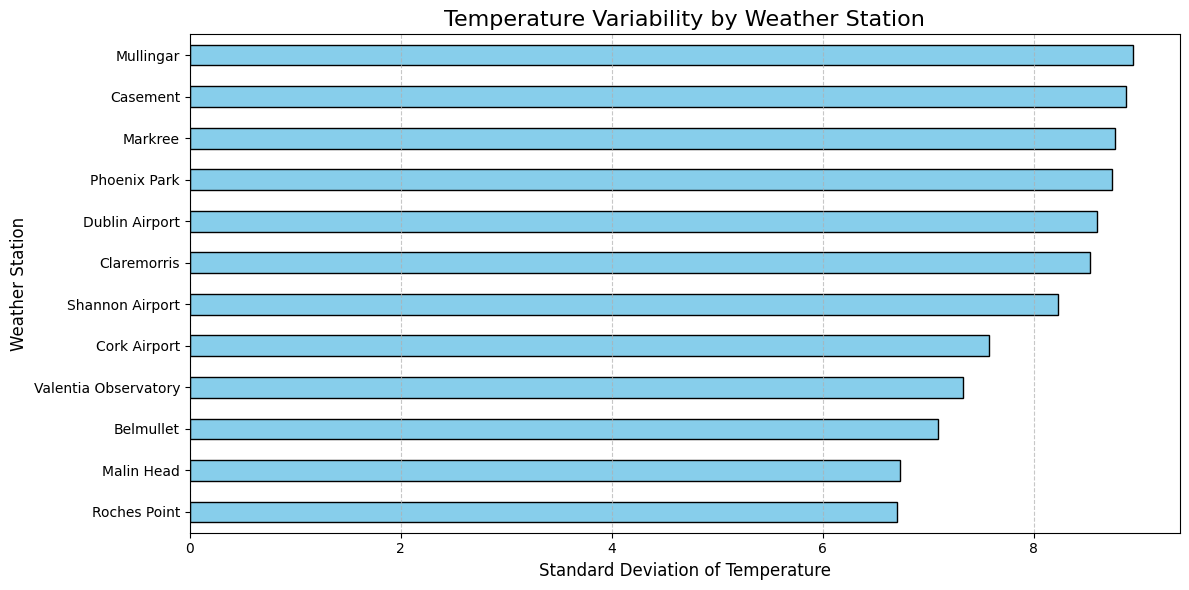

Top 5 stations with highest temperature variability:


Meteorological Weather Station
Mullingar         8.941547
Casement          8.872142
Markree           8.773550
Phoenix Park      8.740145
Dublin Airport    8.604658
Name: VALUE, dtype: float64

In [60]:
#calculating temperature variability for each weather station
station_variability = (
    clean_df.groupby('Meteorological Weather Station')['VALUE']
    .std()
    .sort_values(ascending=False)
)

#plotting variability values as a bar chart
plt.figure(figsize=(12,6))
station_variability.plot(
    kind='barh',
    color='skyblue',
    edgecolor='black'
)
plt.title("Temperature Variability by Weather Station", fontsize=16)
plt.xlabel("Standard Deviation of Temperature", fontsize=12)
plt.ylabel("Weather Station", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#displaying stations with highest temperature variability
print("Top 5 stations with highest temperature variability:")
display(station_variability.head())

Research Question 4: Has the frequency of temperature anomalies changed over time (2009–2023)?
Yes, the frequency of temperature anomalies has changed over time rather than remaining constant. The plot shows noticeable year-to-year fluctuations, with some years (such as 2010 and 2018) recording a much higher number of anomalies, while other years show relatively fewer extreme events. In the later years of the study period (post-2016), anomaly counts generally appear higher and more frequent, suggesting an increase in extreme temperature occurrences compared to the early years.

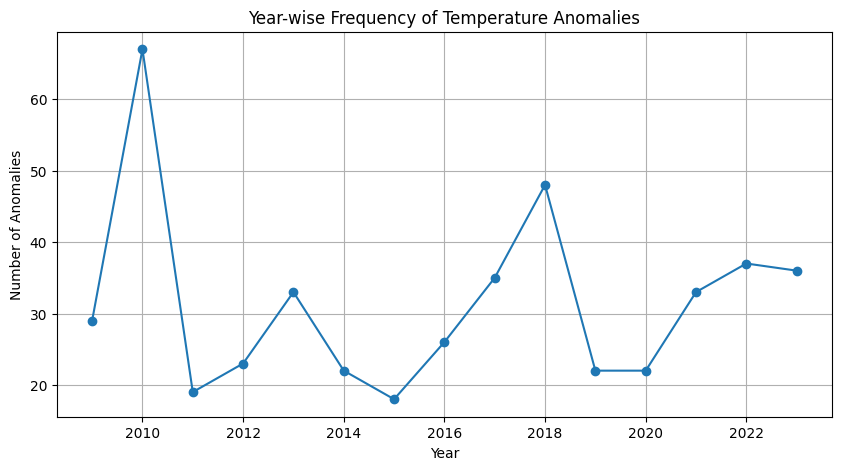

Year
2009    29
2010    67
2011    19
2012    23
2013    33
dtype: int64


In [61]:
#find overall average temperature and standard deviation
mean_val = clean_df['VALUE'].mean()
std_val = clean_df['VALUE'].std()

#defining anomaly limits
upper = mean_val + 2 * std_val
lower = mean_val - 2 * std_val

#identify anomalous temperature values
anomalies = clean_df[
    (clean_df['VALUE'] > upper) | (clean_df['VALUE'] < lower)
]
#counting how many anomalies occur each year
anomaly_counts = anomalies.groupby('Year').size()

#plotting year wise anomaly frequency
plt.figure(figsize=(10,5))
plt.plot(anomaly_counts.index, anomaly_counts.values, marker='o')
plt.title("Year-wise Frequency of Temperature Anomalies")
plt.xlabel("Year")
plt.ylabel("Number of Anomalies")
plt.grid(True)
plt.show()

print(anomaly_counts.head())

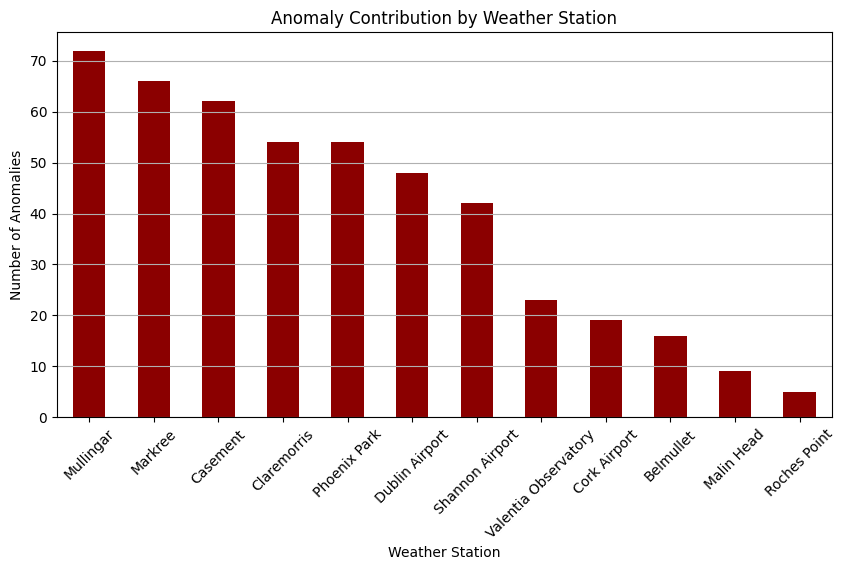

Meteorological Weather Station
Mullingar       72
Markree         66
Casement        62
Claremorris     54
Phoenix Park    54
dtype: int64


In [62]:
#group anomalies by weather station
station_anomalies = anomalies.groupby(
    'Meteorological Weather Station'
).size().sort_values(ascending=False)

#visualize anomaly contribution by station
plt.figure(figsize=(10,5))
station_anomalies.plot(kind='bar', color='darkred')
plt.title("Anomaly Contribution by Weather Station")
plt.xlabel("Weather Station")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

print(station_anomalies.head())

Research Question 6: Are recent years post 2018 warmer on average compared to earlier years?

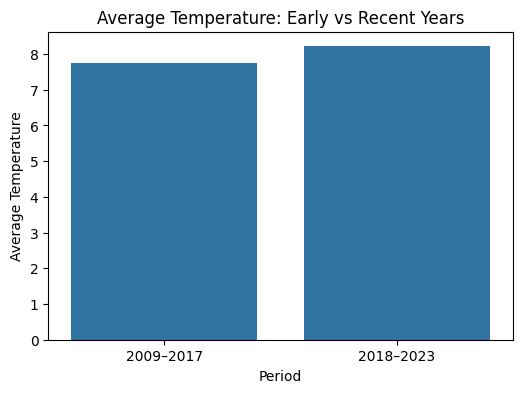

      Period  Average Temperature
0  2009–2017             7.747494
1  2018–2023             8.212106


In [63]:
# RQ11: Early vs recent year comparison

#splitting dataset into two time periods
early_period = clean_df[clean_df['Year'] < 2018]['VALUE']
recent_period = clean_df[clean_df['Year'] >= 2018]['VALUE']

#creating a comparison table
comparison_df = pd.DataFrame({
    'Period': ['2009–2017', '2018–2023'],
    'Average Temperature': [
        early_period.mean(),
        recent_period.mean()
    ]
})

#visualizing comparison using bar chart
plt.figure(figsize=(6,4))
sns.barplot(
    x='Period',
    y='Average Temperature',
    data=comparison_df
)
plt.title("Average Temperature: Early vs Recent Years")
plt.ylabel("Average Temperature")
plt.show()

print(comparison_df)
